In [11]:
import json
from pathlib import Path

import jax.numpy as np
import matplotlib.pyplot as plt
import numpy as onp

from region_utils.region import Domain, Subdomain
from region_utils.shapes import Circle, ConvexPolygon
from utils import data_path

Our total domain is given by

$$\Omega =[0,2.2]×[0,0.41]∖B_r(0.2,0.2)$$
$$r = 0.05$$

Let's attempt to place a rectangle over the more complicated part around the cylinder

$$\Omega_1 = [0.1, 2.0] \times [0.1, 0.31] ∖B_r(0.2,0.2)$$
$$\Omega_2 = \Omega \setminus \{B_r(0.2,0.2), \Omega_1\} =  [0,2.2]×[0,0.41] \setminus \{ \Omega_1, ∖B_r(0.2,0.2) \} $$

In [12]:
dom_1_vertices = np.asarray([[0.8,0], [0,0],[0, 0.41], [0.8, 0.41]])
dom_2_vertices = np.asarray([[0.8,0], [2.2,0], [2.2, 0.41], [0.8, 0.41]])

Cylinder = Circle(center=np.array([0.2, 0.2]), radius=0.05, has_boundary=True)
dummy_Cylinder = Circle(center=np.array([0.2, 0.2]), radius=0.05, has_boundary=False)

Left_poly = ConvexPolygon(dom_1_vertices, list(range(4)))
Left_poly.boundary = Left_poly.boundary[:-1]
Right_poly = ConvexPolygon(dom_2_vertices, list(range(4)))
Right_poly.boundary = Right_poly.boundary[:-1]
#Right_domain = ConvexPolygon(omega1_vertecies)


In [13]:
Left_domain = Subdomain([Left_poly], subtraction=[Cylinder])
Right_domain = Subdomain([Right_poly])
#omega2 = Subdomain([InnerRectangle], subtraction=[Cylinder])

domain = Domain([Left_domain, Right_domain])


In [14]:
n_interior = 1000
n_boundary = 300
domain.create_boundary(n_boundary)
domain.create_interior(n_interior, [0, 0], [2.2, 0.41])


(315, 2)
(675, 2)


In [15]:
domain.create_interface(100,(0,1),(np.array([0.8,0]),np.array([0.8,0.41])))

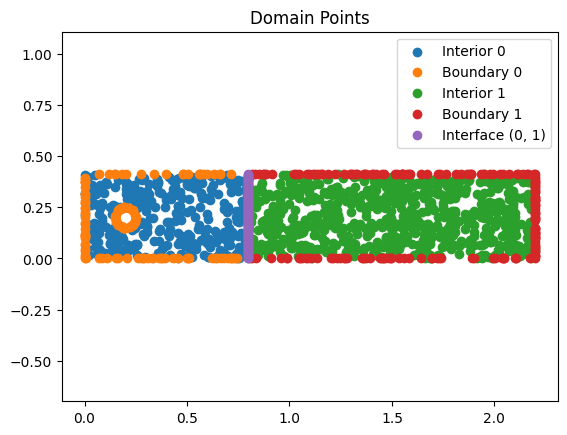

In [16]:
import matplotlib.pyplot as plt

plt.axis("equal")

domain.plot()

In [17]:
def sort_boundaries(domain_dict: dict, file: Path):
    """Sorts the boundary points in the json file and adds the 
        indices of the different boundaries to the dictionary.
        We have four different boundaries; left, wall, right and cylinder.

    Args:
        domain_dict (dict): Dictionary containing the data for the domain. Formated as domain.to_dict_format.
        file (Path): File-path for output file
    """
    
    data = domain_dict
        
    #create buckets for the different boundaries
    for p in data['XPINNs']:
        left_boundary = []
        wall_boundary = []
        right_boundary = []
        cylinder_boundary = []
        for point in p['Boundary points']:
            if np.isclose(point[0], 0):
                left_boundary.append(point)    
            elif np.isclose(point[0], 2.2):
                right_boundary.append(point)
            elif np.isclose(point[1], 0) or np.isclose(point[1], 0.41):
                wall_boundary.append(point)
            else:
                cylinder_boundary.append(point)
                
        #now we combine the buckets and note the indecies of the different boundaries
        all_boundaries = left_boundary + wall_boundary + right_boundary + cylinder_boundary
        left_boundary_index = len(left_boundary)
        wall_boundary_index = left_boundary_index + len(wall_boundary)
        right_boundary_index = wall_boundary_index + len(right_boundary)
        cylinder_boundary_index = right_boundary_index + len(cylinder_boundary)
        
        p['Boundary points'] = all_boundaries
        p['left boundary'] = left_boundary
        p['wall boundary'] = wall_boundary
        p['right boundary'] = right_boundary
        p['cylinder boundary'] = cylinder_boundary
        p['Boundary indices'] = [left_boundary_index, wall_boundary_index, right_boundary_index, cylinder_boundary_index]
    
    with open(file, "w") as outfile:
        json.dump(data, outfile)

In [18]:
domain_dict = domain.to_dict_format()


file = data_path / f"NavierStokes/laminar_decomp_train_{n_boundary}_{n_interior}_v2.json"

sort_boundaries(domain_dict, file)


In [19]:
domain.create_testing_data(200, [0.0, 0.0], [2.2, 0.41])
domain.write_to_file(data_path / "test_decomp_200_v2.json", False)

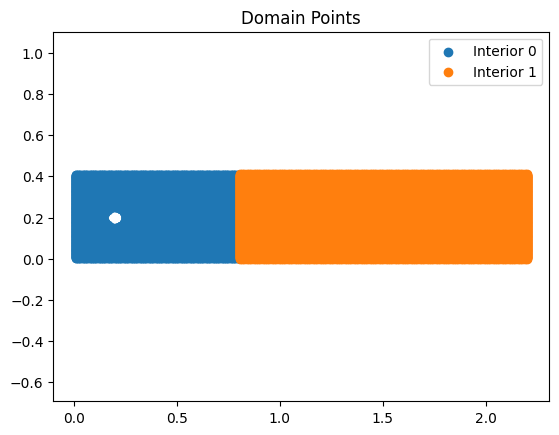

In [20]:
plt.axis("equal")
domain.plot(False)